=============================================== PART 1 ===============================================

In [108]:
from ucimlrepo import fetch_ucirepo

# Abalone 데이터셋 ID를 사용하여 데이터셋을 가져옵니다.
abalone = fetch_ucirepo(id=1)  # Abalone 데이터셋의 ID는 문서나 웹사이트에서 확인한 고유 번호를 사용합니다.

# 데이터 (pandas DataFrame으로)
X = abalone.data.features  # 독립 변수
y = abalone.data.targets   # 종속 변수, 예를 들면 나이 (Rings + 1.5)

# 메타데이터 출력
print(abalone.metadata)

# 변수 정보 출력
print(abalone.variables)


{'uci_id': 1, 'name': 'Abalone', 'repository_url': 'https://archive.ics.uci.edu/dataset/1/abalone', 'data_url': 'https://archive.ics.uci.edu/static/public/1/data.csv', 'abstract': 'Predict the age of abalone from physical measurements', 'area': 'Biology', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Tabular'], 'num_instances': 4177, 'num_features': 8, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['Rings'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C55C7W', 'creators': ['Warwick Nash', 'Tracy Sellers', 'Simon Talbot', 'Andrew Cawthorn', 'Wes Ford'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- 

In [109]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 데이터셋의 경로를 지정합니다. 데이터 파일을 로드할 준비가 되었을 때 이 경로를 실제 경로로 변경하세요.
file_path = 'abalone.data'

# 데이터셋에 적절한 컬럼 이름을 지정합니다.
column_names = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']

# 데이터를 읽어옵니다.
data = pd.read_csv(file_path, names=column_names)

# 'Sex' 컬럼은 범주형 데이터이므로 원-핫 인코딩을 적용할 수 있습니다.
data = pd.get_dummies(data, columns=['Sex'])

# 'Rings'는 목표 변수(타겟)이며, 이를 사용하여 나이를 예측합니다.
# 나이 = 'Rings' + 1.5 (이는 과제의 요구사항에 따라 조정하세요)
y = data['Rings'] + 1.5
X = data.drop('Rings', axis=1)

# 데이터를 훈련 세트와 테스트 세트로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# 분할된 데이터의 크기를 출력하여 확인합니다.
print(f'Training set size: {X_train.shape[0]} samples')
print(f'Test set size: {X_test.shape[0]} samples')


Training set size: 3341 samples
Test set size: 836 samples


In [110]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 수치형 특성을 위한 스케일러 생성
scaler = StandardScaler()

# 모든 수치형 특성 선택 (원-핫 인코딩된 범주형 특성 제외)
numeric_features = ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']

# ColumnTransformer를 사용하여 수치형 특성만 스케일링
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numeric_features)
    ], remainder='passthrough')

# 전처리 및 모델 파이프라인 설정
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# 훈련 데이터 전처리
X_train_preprocessed = model_pipeline.fit_transform(X_train)
X_test_preprocessed = model_pipeline.transform(X_test)

# 이제 X_train_preprocessed와 X_test_preprocessed를 사용하여 모델을 훈련시킬 수 있습니다.


In [111]:
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# 그래디언트 부스팅 모델 초기화
gbr = GradientBoostingRegressor(random_state=24)

# 하이퍼파라미터 분포 설정
param_distributions = {
    'n_estimators': randint(100, 800),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2]  # 0.01에서 0.21 사이의 균일 분포
}

# 랜덤 서치 초기화
random_search = RandomizedSearchCV(gbr, param_distributions=param_distributions, n_iter=100, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, random_state=24)

# 랜덤 서치 수행
random_search.fit(X_train_preprocessed, y_train)

# 최적의 하이퍼파라미터 출력
print("Best hyperparameters:", random_search.best_params_)

# 최적의 모델을 사용한 예측
best_gbr = random_search.best_estimator_
y_pred_gbr = best_gbr.predict(X_test_preprocessed)

# 성능 평가
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))

# 결과 출력
print("Gradient Boosting MAE:", mae_gbr)
print("Gradient Boosting RMSE:", rmse_gbr)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 17, 'min_samples_split': 4, 'n_estimators': 708}
Gradient Boosting MAE: 1.5098473395966379
Gradient Boosting RMSE: 2.1705879165438646


=============================================== PART 2 ===============================================

In [112]:
# 2.1 Divide the ObesityDataSet.csv into train, validation and test sets (train:validation:test = 7:1:2, random_state=24)
from sklearn.model_selection import train_test_split

# 데이터 로드
file_path = 'ObesityDataSet.csv'
data = pd.read_csv(file_path)

# 특성과 타겟 분리 (여기서는 'NObeyesdad'가 타겟 변수라고 가정)
X = data.drop('NObeyesdad', axis=1)
y = data['NObeyesdad']

# 첫 번째 분할: 훈련+검증 세트와 테스트 세트
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# 두 번째 분할: 훈련 세트와 검증 세트
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=24)  # 0.125 * 0.8 = 0.1

# 확인 출력
print(f'Training set size: {X_train.shape[0]} samples')
print(f'Validation set size: {X_val.shape[0]} samples')
print(f'Test set size: {X_test.shape[0]} samples')

Training set size: 1477 samples
Validation set size: 211 samples
Test set size: 423 samples


In [113]:
# 2.2 Apply appropriate preprocessing steps before feeding the dataset into the model

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# 범주형 변수와 수치형 변수 선택
categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
numeric_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

# 전처리 변환기 생성
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# ColumnTransformer로 범주형과 수치형 데이터에 각각 다른 변환 적용
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 전체 파이프라인 구축
clf = Pipeline(steps=[('preprocessor', preprocessor)])

# 데이터 전처리
X_train_preprocessed = clf.fit_transform(X_train)
X_val_preprocessed = clf.transform(X_val)
X_test_preprocessed = clf.transform(X_test)


In [114]:
# 2.3 Create at least two classification models (e.g., SVC, Random Forest) which predicts the obesity level of a given patient

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# SVC 모델 초기화 및 훈련
svc_model = SVC(kernel='linear', random_state=24)
svc_model.fit(X_train_preprocessed, y_train)

# 랜덤 포레스트 모델 초기화 및 훈련
rf_model = RandomForestClassifier(n_estimators=100, random_state=24)
rf_model.fit(X_train_preprocessed, y_train)

# 각 모델에 대한 예측 수행
y_pred_svc = svc_model.predict(X_val_preprocessed)
y_pred_rf = rf_model.predict(X_val_preprocessed)

# 모델 성능 평가
print("SVC Model Accuracy:", accuracy_score(y_val, y_pred_svc))
print("Random Forest Model Accuracy:", accuracy_score(y_val, y_pred_rf))

# 분류 리포트 출력
print("\nClassification Report for SVC:")
print(classification_report(y_val, y_pred_svc))

print("\nClassification Report for Random Forest:")
print(classification_report(y_val, y_pred_rf))


SVC Model Accuracy: 0.966824644549763
Random Forest Model Accuracy: 0.933649289099526

Classification Report for SVC:
                     precision    recall  f1-score   support

Insufficient_Weight       0.92      1.00      0.96        35
      Normal_Weight       1.00      0.88      0.94        26
     Obesity_Type_I       1.00      1.00      1.00        34
    Obesity_Type_II       1.00      1.00      1.00        34
   Obesity_Type_III       1.00      1.00      1.00        25
 Overweight_Level_I       1.00      0.89      0.94        36
Overweight_Level_II       0.84      1.00      0.91        21

           accuracy                           0.97       211
          macro avg       0.97      0.97      0.96       211
       weighted avg       0.97      0.97      0.97       211


Classification Report for Random Forest:
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.89      0.94        35
      Normal_Weight       0.73      0.92   

Confusion Matrix:
 [[45  2  0  0  0  0  0]
 [ 2 52  0  0  0  0  1]
 [ 0  0 71  1  0  0  4]
 [ 0  0  1 69  0  0  0]
 [ 0  0  1  0 56  0  0]
 [ 0  5  0  0  0 48  2]
 [ 0  3  1  0  0  1 58]]


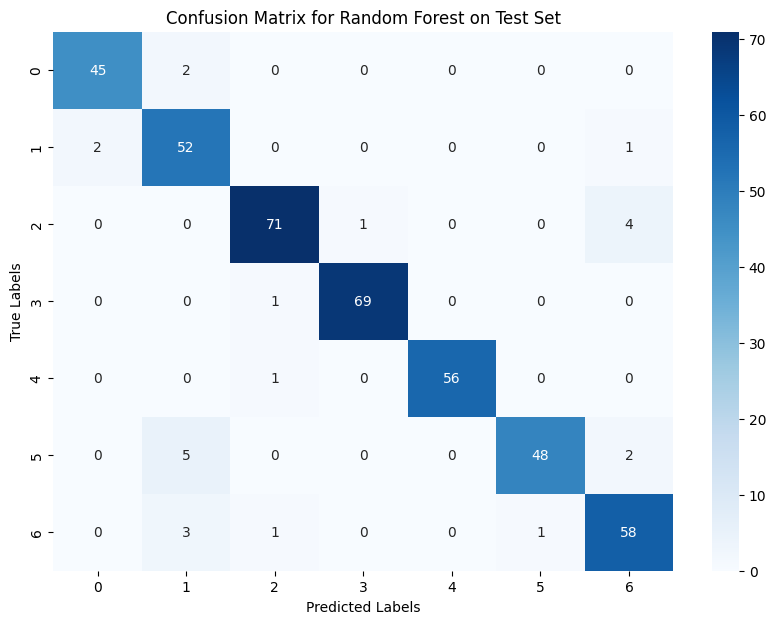

Accuracy of the Random Forest model: 94.33%


In [115]:
# Output a confusion matrix of the model using the test set 
# Minimum accuracy of the classification model should be 87.0% and bonus points will be given if the model accuracy is above 93.0%
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 테스트 세트에 대한 예측 수행
y_pred_test_rf = rf_model.predict(X_test_preprocessed)

# 혼동 행렬 생성
cm = confusion_matrix(y_test, y_pred_test_rf)
print("Confusion Matrix:\n", cm)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix for Random Forest on Test Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# 정확도 계산
accuracy = accuracy_score(y_test, y_pred_test_rf)
print("Accuracy of the Random Forest model: {:.2f}%".format(accuracy * 100))

================================== PART 3 ==================================

In [116]:
# Concatenate the train and validation sets from ’Part 2: Classification’ to create a "new training set".

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 데이터 로드 및 열 확인 (경로는 데이터 위치에 따라 다를 수 있습니다)
file_path = 'ObesityDataSet.csv'
data = pd.read_csv(file_path)

X_new_train = pd.concat([X_train, X_val], axis=0)
y_new_train = pd.concat([y_train, y_val], axis=0)

In [117]:
# Using K-Means Clustering, form k number of clusters in the "new training set".

# 범주형 및 수치형 변수 설정
categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
numeric_features = data.columns.difference(categorical_features + ['NObeyesdad'])

# 전처리기 구성
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])
# 파이프라인 설정 및 K-Means 클러스터링
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('kmeans', KMeans(n_clusters=3, random_state=24))])
pipeline.fit(X_new_train)

# 클러스터 레이블 추출
cluster_labels = pipeline.named_steps['kmeans'].labels_

C:\Users\heal\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\heal\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


In [118]:
# 클러스터 레이블과 타겟 레이블 결합
clustered_data = pd.DataFrame(X_new_train)
clustered_data['Cluster'] = cluster_labels
clustered_data['Label'] = y_new_train

# 각 클러스터의 다수 레이블 결정
majority_labels = clustered_data.groupby('Cluster')['Label'].agg(lambda x: x.mode()[0])

# 클러스터별 샘플 수 계산
cluster_sample_counts = clustered_data['Cluster'].value_counts()

# 결과 출력
print("Majority labels by cluster:")
for cluster, label in majority_labels.items():
    print(f"Cluster {cluster}: {label}")
print("\nSample counts by cluster:")
print(cluster_sample_counts)


Majority labels by cluster:
Cluster 0: Insufficient_Weight
Cluster 1: Obesity_Type_III
Cluster 2: Obesity_Type_II

Sample counts by cluster:
2    660
0    624
1    404
Name: Cluster, dtype: int64


In [119]:
from sklearn.metrics import pairwise_distances

# 테스트 데이터 전처리 (예시: X_test가 이미 존재한다고 가정)
X_test_preprocessed = pipeline.named_steps['preprocessor'].transform(X_test)

# 클러스터 중심점 가져오기
centroids = pipeline.named_steps['kmeans'].cluster_centers_

# 각 테스트 샘플과 클러스터 중심 사이의 유클리디언 거리 계산
distances = pairwise_distances(X_test_preprocessed, centroids, metric='euclidean')

# 각 샘플에 대해 가장 가까운 클러스터 찾기
closest_clusters = np.argmin(distances, axis=1)

# 각 클러스터의 다수결 레이블을 이용하여 테스트 샘플 레이블 예측
predicted_labels = [majority_labels[cluster] for cluster in closest_clusters]

# 결과 출력
print("Predicted labels for test samples:")
for i, label in enumerate(predicted_labels):
    print(f"Sample {i}: Predicted label = {label}")

Predicted labels for test samples:
Sample 0: Predicted label = Obesity_Type_II
Sample 1: Predicted label = Insufficient_Weight
Sample 2: Predicted label = Insufficient_Weight
Sample 3: Predicted label = Obesity_Type_III
Sample 4: Predicted label = Insufficient_Weight
Sample 5: Predicted label = Insufficient_Weight
Sample 6: Predicted label = Obesity_Type_II
Sample 7: Predicted label = Obesity_Type_III
Sample 8: Predicted label = Insufficient_Weight
Sample 9: Predicted label = Insufficient_Weight
Sample 10: Predicted label = Obesity_Type_III
Sample 11: Predicted label = Obesity_Type_II
Sample 12: Predicted label = Insufficient_Weight
Sample 13: Predicted label = Obesity_Type_II
Sample 14: Predicted label = Insufficient_Weight
Sample 15: Predicted label = Insufficient_Weight
Sample 16: Predicted label = Obesity_Type_II
Sample 17: Predicted label = Obesity_Type_II
Sample 18: Predicted label = Obesity_Type_II
Sample 19: Predicted label = Obesity_Type_II
Sample 20: Predicted label = Insuffi

In [120]:
import numpy as np
from sklearn.metrics import accuracy_score

# 데이터셋에서 고유 레이블 수 확인
unique_labels_count = y_new_train.nunique()

# 최적 k 값 탐색을 위한 범위 설정
min_k = unique_labels_count
max_k = unique_labels_count + 3  # 예시로 +3까지 검토

best_k = min_k
best_accuracy = 0

# k 값에 따라 클러스터링 반복 실행
for k in range(min_k, max_k + 1):
    # 파이프라인 재설정 및 K-Means 클러스터링
    pipeline.set_params(kmeans=KMeans(n_clusters=k, random_state=24))
    pipeline.fit(X_new_train)

    # 클러스터 레이블과 타겟 레이블 결합
    clustered_data = pd.DataFrame(X_new_train)
    clustered_data['Cluster'] = pipeline.named_steps['kmeans'].labels_
    clustered_data['Label'] = y_new_train

    # 다수결 레이블 결정
    majority_labels = clustered_data.groupby('Cluster')['Label'].agg(lambda x: x.mode()[0])

    # 테스트 데이터 전처리 및 클러스터링
    X_test_preprocessed = pipeline.named_steps['preprocessor'].transform(X_test)
    centroids = pipeline.named_steps['kmeans'].cluster_centers_
    distances = pairwise_distances(X_test_preprocessed, centroids, metric='euclidean')
    closest_clusters = np.argmin(distances, axis=1)
    predicted_labels = [majority_labels[cluster] for cluster in closest_clusters]

    # 정확도 계산 및 최적 k 값 업데이트
    accuracy = accuracy_score(y_test, predicted_labels)
    print(f"Accuracy for k={k}: {accuracy * 100:.2f}%")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

# 최적의 k 값 및 해당 정확도 출력
print(f"Optimal k value is {best_k} with an accuracy of {best_accuracy * 100:.2f}%")


Accuracy for k=7: 41.37%


C:\Users\heal\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\heal\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\Users\heal\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\heal\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chun

Accuracy for k=8: 41.13%


C:\Users\heal\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\heal\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


Accuracy for k=9: 42.32%
Accuracy for k=10: 40.19%
Optimal k value is 9 with an accuracy of 42.32%


C:\Users\heal\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\heal\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
